In [1]:
%pylab inline
import sklearn.cluster
import itertools
import sklearn.decomposition

Populating the interactive namespace from numpy and matplotlib


In [2]:
def calculate_confusion_matrix(data, datalabels, xlabels, ylabels):
    cm = np.zeros((len(ylabels), len(xlabels)))
    for i in ylabels:
        cm[i,:] = data[datalabels == i,:].mean(axis=0)
        
    maxs = cm.argmax(axis=0)
    sorted_xlabels = sorted(xlabels, lambda a, b: cmp(maxs[xlabels.index(a)], maxs[xlabels.index(b)]))
    sorted_cm = cm[:,[xlabels.index(xlabel) for xlabel in sorted_xlabels]]        
        
    return sorted_cm, sorted_xlabels, [str(l) for l in ylabels]


In [3]:
def plot_confusion_matrix(cm, xclasses, yclasses,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          xlabel='Predicted label', ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xtick_marks = np.arange(len(xclasses))
    plt.xticks(xtick_marks, xclasses, rotation=90)
    ytick_marks = np.arange(len(yclasses))
    plt.yticks(ytick_marks, yclasses)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [4]:
orig_data = data = np.load("vessels_gear_embedding.npz")["data"]

In [16]:
width = 19200
labels = ['cargo', 'tanker', 'trawlers', 'sailing', 'set_gillnets', 'pole_and_line', 'motor_passenger', 'reefer', 'tug', 'set_longlines', 'pots_and_traps', 'other_not_fishing', 'gear', 'squid_jigger', 'seismic_vessel', 'purse_seines', 'drifting_longlines', 'other_fishing', 'trollers']
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for idx, label in enumerate(labels)}


In [6]:
columns = {
    "engine_power": width+0,
    "length": width+1,
    "tonnage": width+2,
    "mmsi": width+3,
    "max_label": width+4,
    "max_label_probability": width+5,
    "label_scores": width+6}

In [7]:
datasize = 10000
res = None
for idx in xrange(0, len(labels)):
    chunk = data[data[:,width+4] == idx]
    chunk = chunk[np.random.randint(len(chunk), size=datasize / len(labels)),:]
    if res is None:
        res = chunk
    else:
        res = np.append(res, chunk, axis=0)
data = res

In [8]:
stds = data[:,:width].std(axis=0)
means = data[:,:width].mean(axis=0)
data[:,:width] -= means
data[:,:width] /= (stds+1e-30)

In [9]:
transform = sklearn.decomposition.PCA(n_components=50)

transform.fit(data[:,:width])
transformed_data = transform.transform(data[:,:width])

Confusion matrix, without normalization


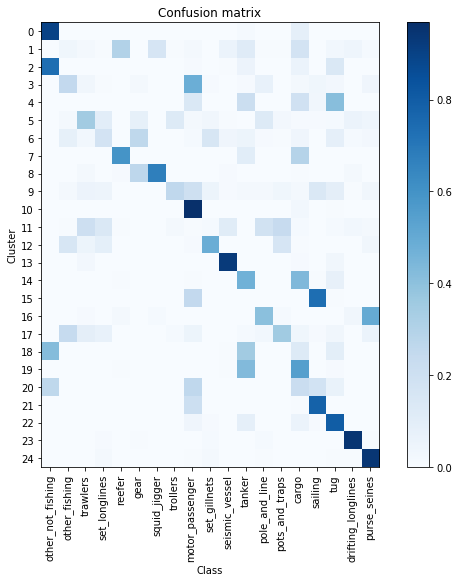

In [10]:
nclusters=25
clustering = sklearn.cluster.AgglomerativeClustering(linkage="ward", n_clusters=nclusters)
c = clustering.fit(transformed_data)
cm, xlabels, ylabels = calculate_confusion_matrix(
    data[:,width+6:width+6+len(labels)],
    clustering.labels_,
    labels,
    range(0, nclusters))
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, xlabels, ylabels, ylabel='Cluster', xlabel='Class')
plt.show()

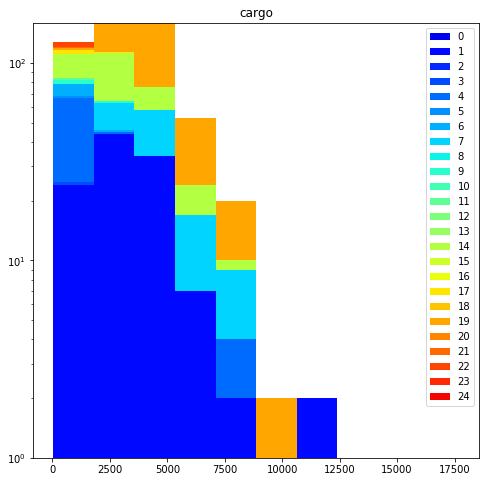

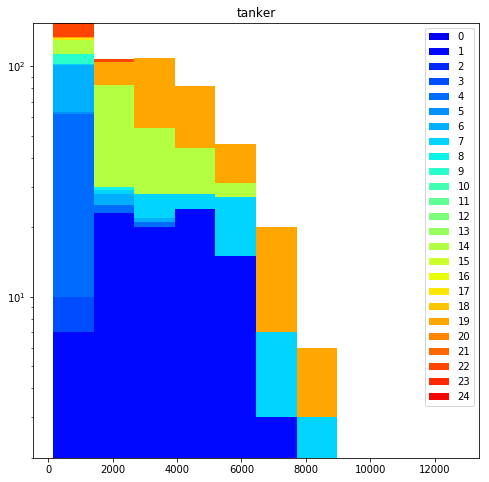

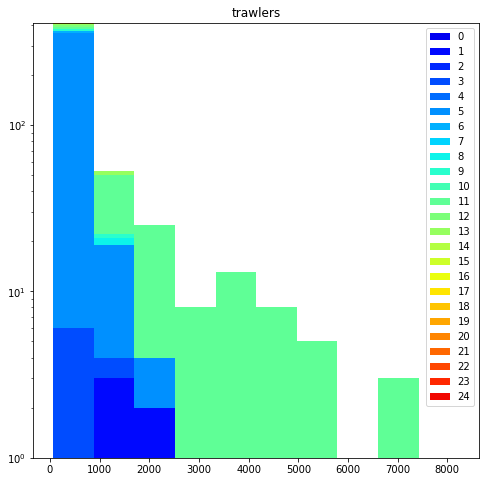

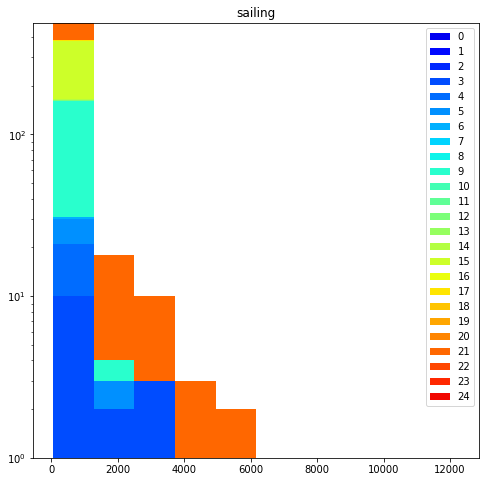

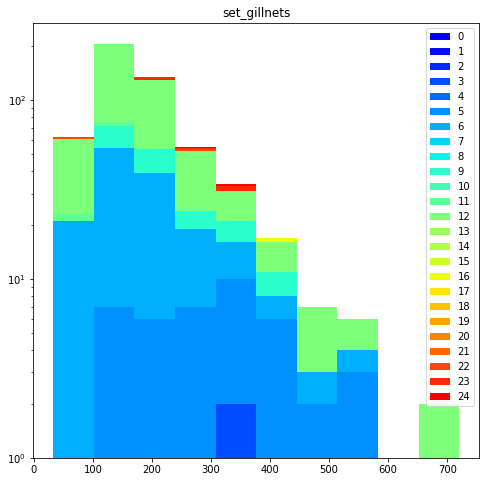

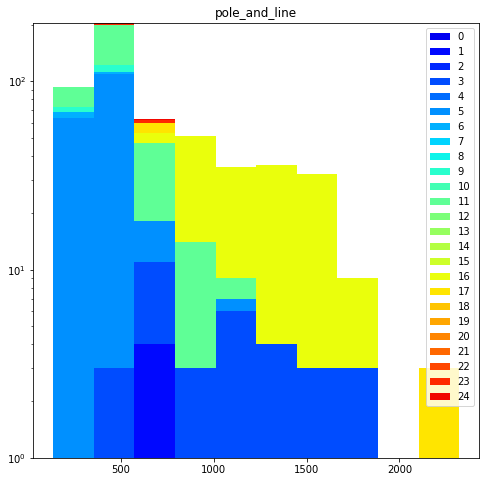

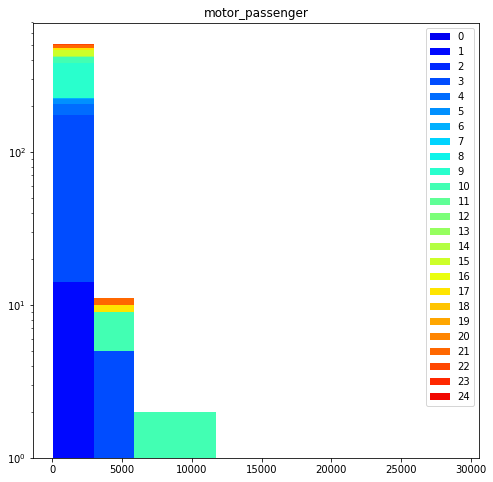

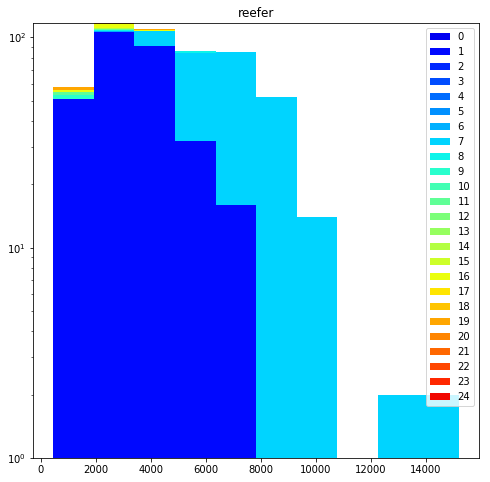

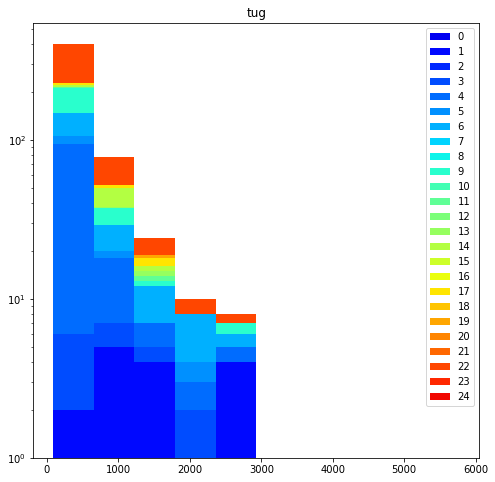

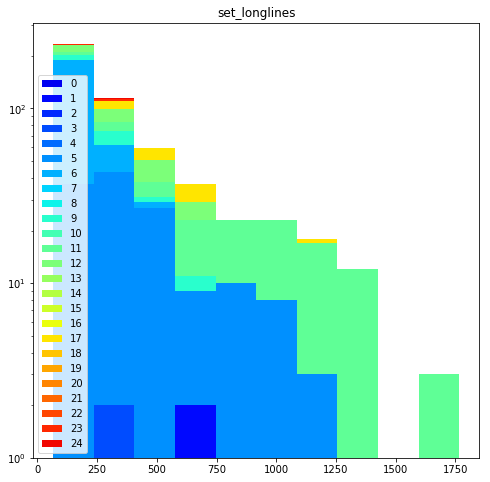

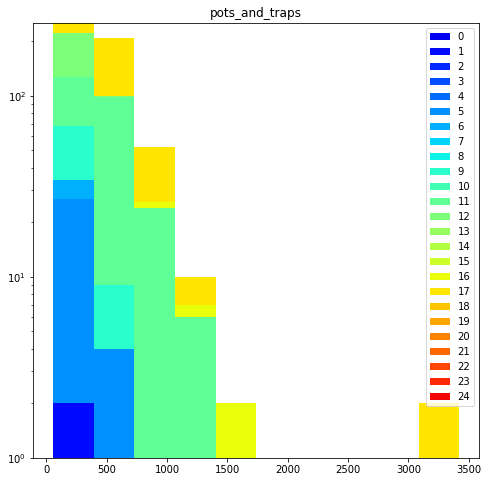

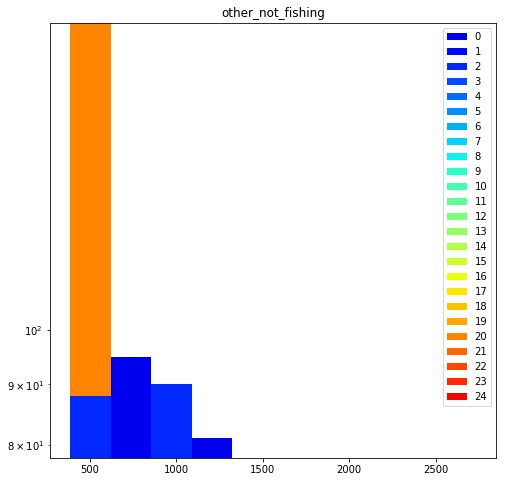

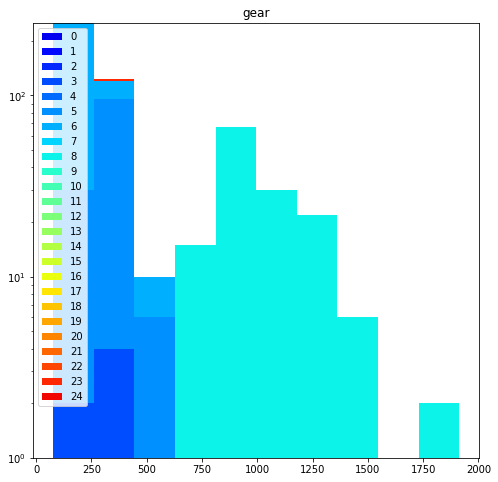

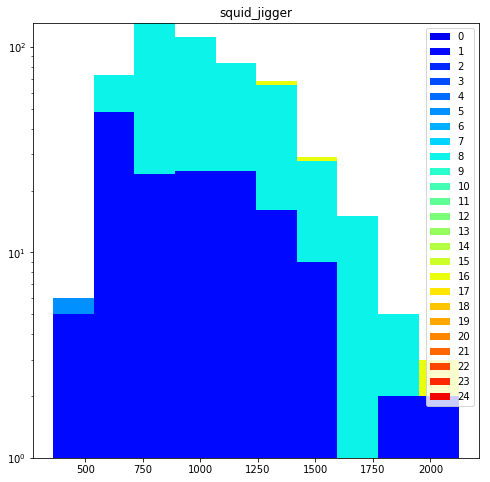

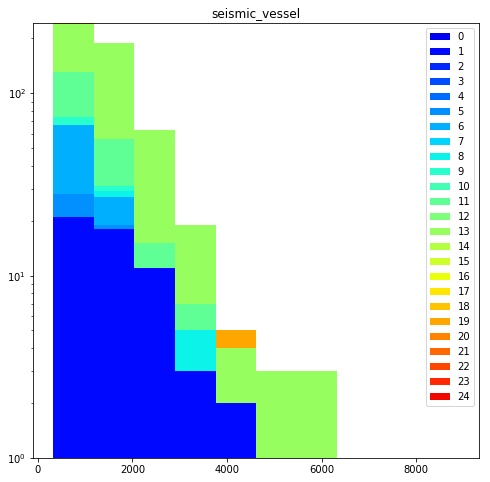

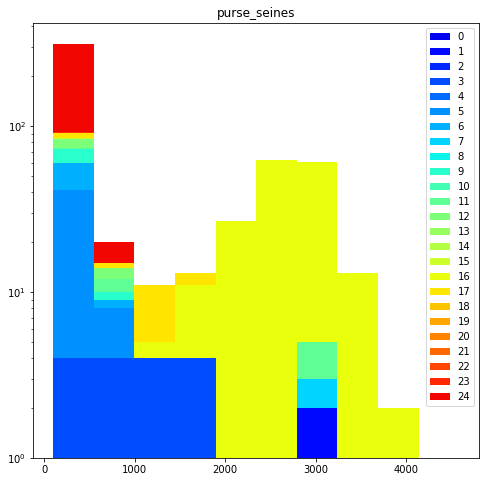

In [ ]:
color = plt.cm.jet(np.linspace(0.1,0.9,nclusters))
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))

allpwr = data[:,columns["engine_power"]]
for idx, label in enumerate(labels):
    #if label not in ('purse_seines',): continue
    plt.figure(figsize=(8,8))
    plt.title(label)
    pwrs = []
    for clusteridx in xrange(0, nclusters):
        rows = (data[:,columns["max_label"]]==idx) & (clustering.labels_ == clusteridx)
        pwrs.append(allpwr[rows])

    n, bins, patches = plt.hist(
            pwrs, 10,
            histtype="barstacked",
            color=hexcolor,
            log=True,
            label=[str(i) for i in xrange(0, nclusters)])
    plt.legend()
    plt.show()